In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.abspath(".."))
from src.data import dataset
from src.modeling import train, predict
from src.visualization import plots
import importlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Cargar datos

Se escogerá Febrero, Marzo y Abril como evaluación, usando Enero de training

In [ ]:
importlib.reload(dataset)
dataset_obj = dataset.Dataset()
dataset_obj.change_configs({
    "TRAINING_MONTH": "2020-01",
    "EVAL_MONTHS": ['2020-02', '2020-03', '2020-04']
})
dataset_obj.get_preprocessed_data()

## Entrenamiento

In [42]:
importlib.reload(train)
train_obj = train.Training()
train_obj.change_configs({
    "TRAINING_MONTH": "2020-01",
    "REDUCE_TRAINING": False
})
train_obj.fit_model()
model = train_obj.get_trained_model()

In [32]:
model

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Evaluación

In [5]:
importlib.reload(predict)
eval_obj = predict.Evaluation()
eval_obj.change_configs({
    "TRAINING_MONTH": '2020-01',
    "EVAL_MONTHS": ['2020-02', '2020-03', '2020-04']
})
f1_scores = eval_obj.eval_model()
f1_scores

,month,f1_score
1,2020-01,0.729677
2,2020-02,0.734925
3,2020-03,0.725833
0,2020-04,0.611723


## Visualizaciones

se observa una caída apreciable de f1 score en abril

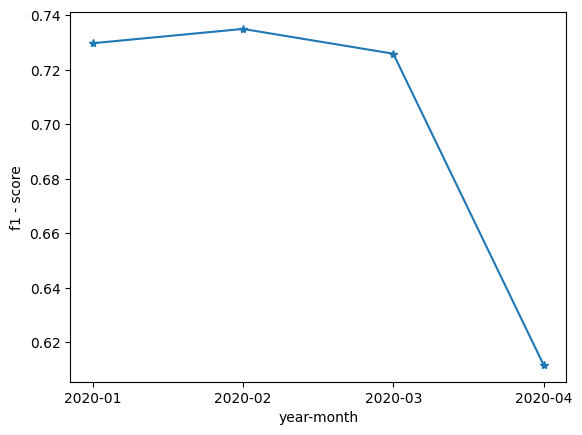

In [17]:
importlib.reload(plots)
plots_obj = plots.PlotsGeneration()
plots_obj.change_configs({
    "TRAINING_MONTH": '2020-01',
    "EVAL_MONTHS": ['2020-02', '2020-03', '2020-04']
})
plots_obj.plot_scores(f1_scores)

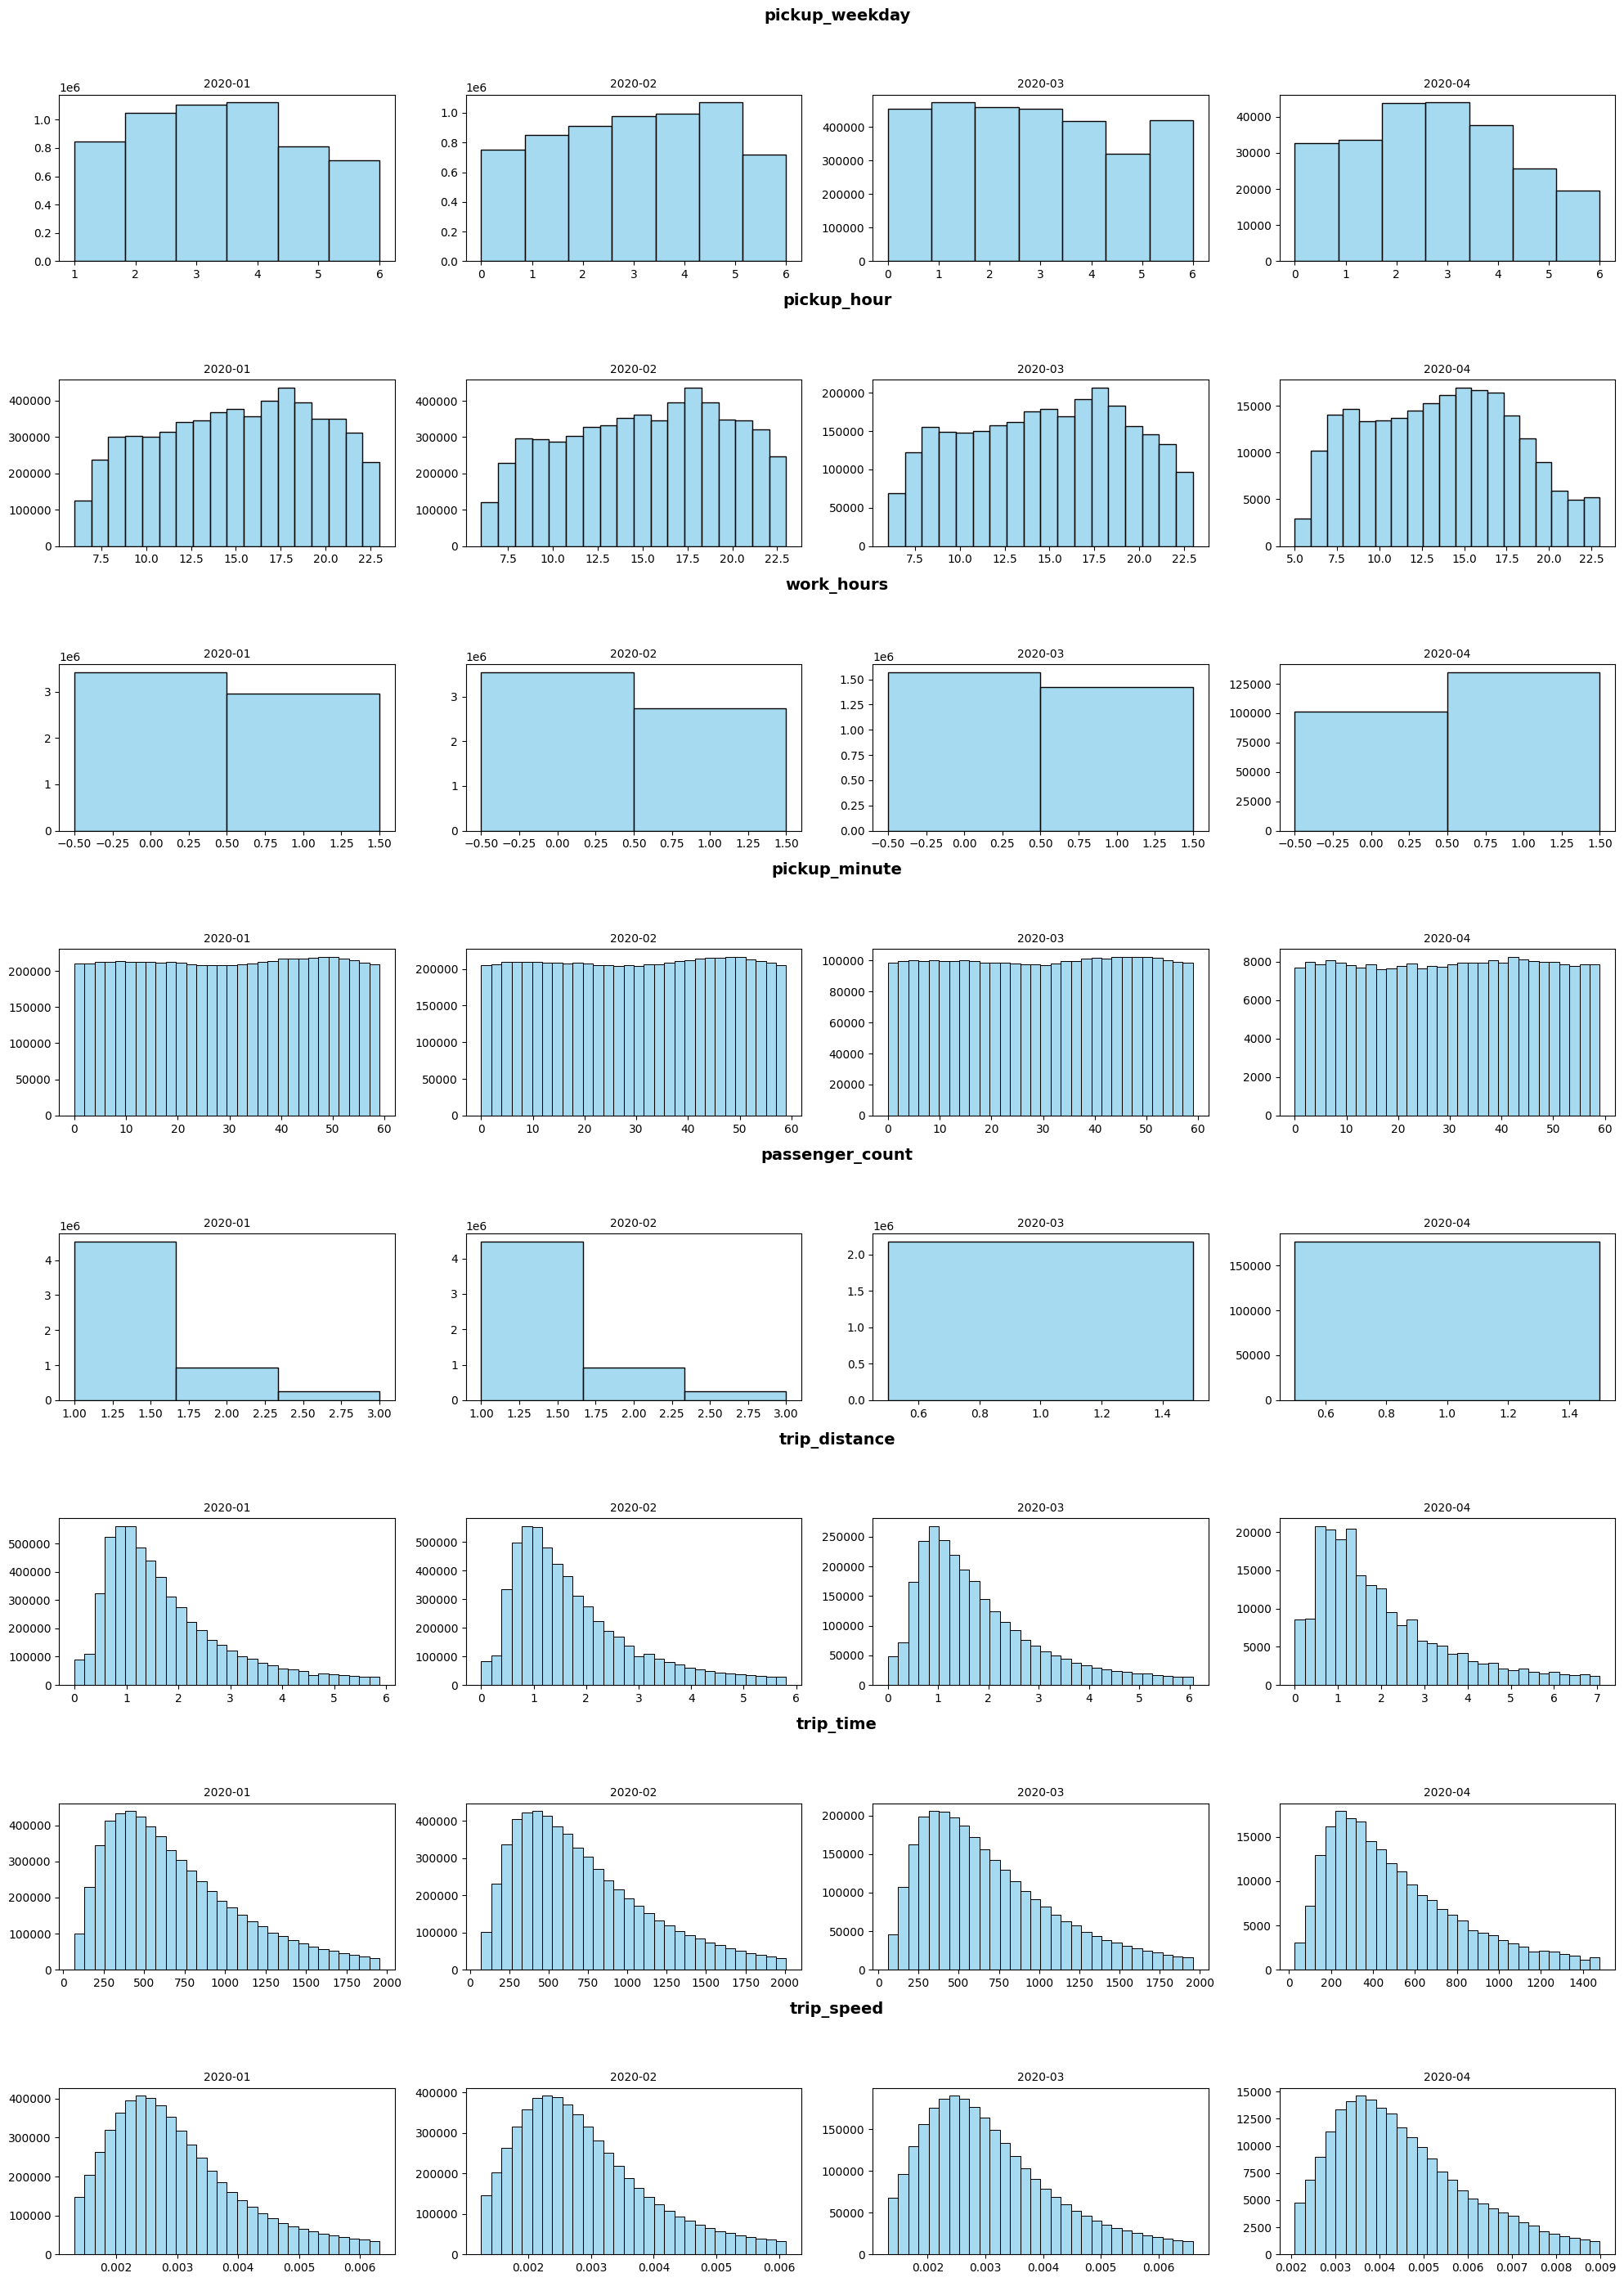

In [7]:
plots_obj.generate_histograms()

Observando las distribuciones, se puede ver que en algunos casos hay diferencias radicales en las distribuciones de features para Abril. La variable trip_time se desplaza hacia la izquierda radicalmente (tiene viajes más cortos en tiempo), pickup_hour tiene un comportamiento diferentes para horas más altas. Estos drift en features particulares contribuyen a la baja de performance del modelo, ya que se entrenó en distribuciones diferentes a cómo se distribuyen en el mes de evaluación.

Cabe destacar que para visualizar la forma de las distribuciones se filtraron outliers para evitar que dominen cada histograma. Con el fin de ver el movimiento de outliers, se visualizan boxplots a continuación. No se filtran todos los outliers en este caso, sino que se filtran outliers extremos, para visualizar correctamente cada caja

/Users/diego/Desktop/Desarrollo de Proyectos y Productos de Datos/Tarea-1-Desarrollo-de-Proyectos-y-Productos-de-Datos/src/visualization/plots.py:115: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  lower_limit = q1 - 1.5 * iqr
/Users/diego/Desktop/Desarrollo de Proyectos y Productos de Datos/Tarea-1-Desarrollo-de-Proyectos-y-Productos-de-Datos/src/visualization/plots.py:115: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  lower_limit = q1 - 1.5 * iqr


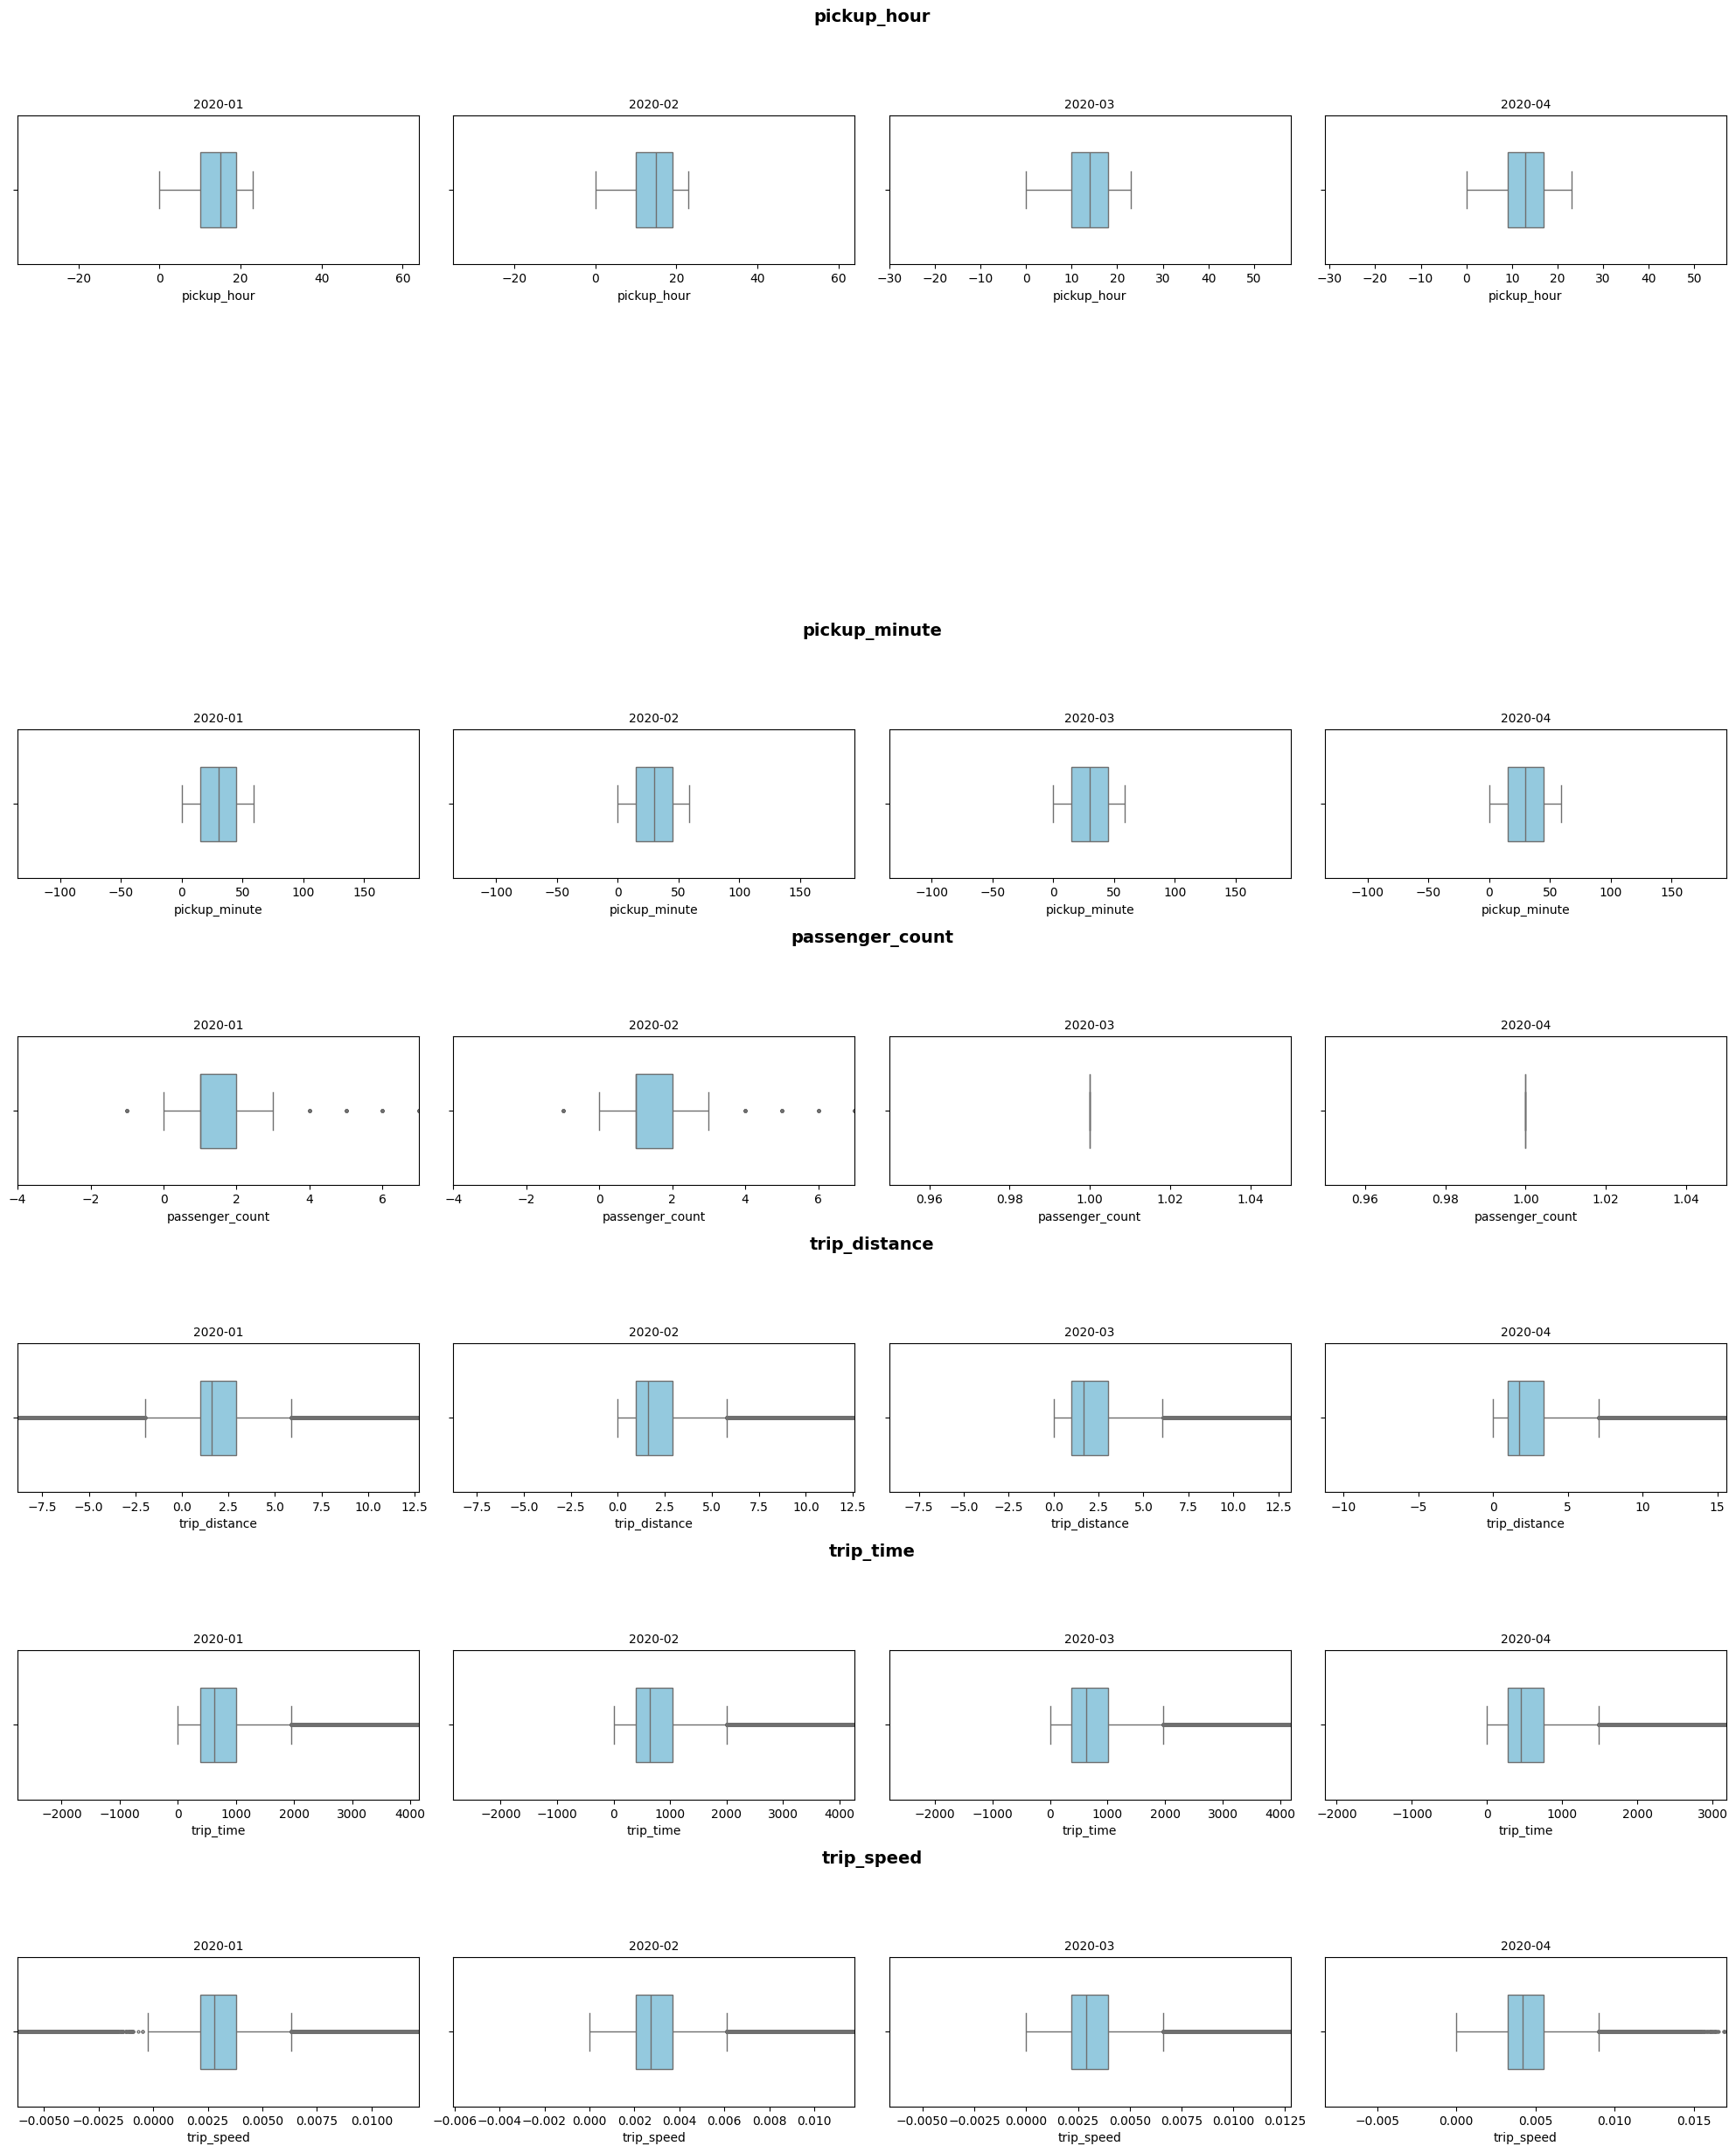

In [18]:
plots_obj.generate_boxplots()

Se puede ver que trip_speed se entrenó en una mediana notoriamente más baja (Enero) que la que existe en Abril. En el caso de trip_distance se entrenó con outliers inferiores, los cuales no volvieron a aparecer en el resto de meses. Adicionalmente el passenger_count en Enero y Febrero es tendiente a 2, mientras que en Marzo y Abril es 1. Los boxplots corroboran la tendencia al drift 

La solución a este problema sería un reentrenamiento para evaluar desde Abril en adelante usando más meses de entrenamiento y tener un moniotoreo mensual de cada vez que se detecte drift (como alerta de re-entrenamiento). Adicionalmente, se recomienda un mejor tratamiento de outliers y de missings, ya que se llenaron con -1 sin experimentación (pudiendo analizar si se podían imputar).